In [2]:
from io import StringIO
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft

In [3]:
from dataclasses import dataclass

@dataclass
class CONFIG:
    PATH_TO_DATA = './WISDM_at_v2.0/WISDM_at_v2.0_raw.txt'
    SAMPLING_RATE_HZ = 20 # Hz (50ms)
    FILTER_OUTLIER_PERCENTILE = 0.99
    FILTER_MAD_FACTOR = 20


    class RAW_DATA_FEATURES:
        pass

    class WINDOWED_FEATURES:
        WINDOW_SIZE = 20 # timesteps pro window, 10 = 500ms

In [4]:
## Data Info
# [user],[activity],[timestamp],[x-acceleration],[y-accel],[z-accel];
# int, string, int, float, float, float

# This line is a representative example:
# 33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;

def read_in_dataset(path_to_data):
    with open(path_to_data, 'r') as f:
        data = f.read()

    data = data.replace(';', '')

    # prune rows with missing data ( not exactly 5 commas)
    data = data.split('\n')
    data = [line for line in data if line.count(',') == 5]

    # remove empty lines
    data = [line for line in data if line]

    return data


def convert_to_dataframe(data):
    data = '\n'.join(data)
    data = StringIO(data)
    df = pd.read_csv(data, header=None)
    df.columns = ['user', 'activity', 'timestamp', 'x_acc', 'y_acc', 'z_acc']

    return df

In [5]:
data = read_in_dataset(CONFIG.PATH_TO_DATA)

df = convert_to_dataframe(data)

In [6]:
df.head()

,user,activity,timestamp,x_acc,y_acc,z_acc
0,1679,Walking,1370520469556,0.294132,-0.635605,-0.226936
1,1679,Walking,1370520469606,-0.499688,-0.604451,-0.226020
2,1679,Walking,1370520469656,-2.178345,0.713491,0.372017
3,1679,Walking,1370520469706,-2.797763,1.354899,-0.277638
4,1679,Walking,1370520469756,-2.167961,-1.327716,-0.554971


In [7]:
# for now, we will only use walking data
df = df[df['activity'] == 'Walking']

# Create a mapping from original user IDs to new user IDs
unique_user_ids = df['user'].unique()
user_id_mapping = {int(original_id): new_id for new_id, original_id in enumerate(unique_user_ids)}

# Apply the mapping to create a new user_id column
df['new_user_id'] = df['user'].map(user_id_mapping)

# as we only use walking we can drop the activity
df= df.drop(columns=['activity'])

In [8]:
# Create a new column for total acceleration
def total_acceleration(row: pd.Series) -> float:
    return np.sqrt(row['x_acc']**2 + row['y_acc']**2 + row['z_acc']**2)

df['total_acc'] = df.apply(total_acceleration, axis=1)

In [9]:
df.head(1)

,user,timestamp,x_acc,y_acc,z_acc,new_user_id,total_acc
0,1679,1370520469556,0.294132,-0.635605,-0.226936,0,0.736212


In [10]:
# # we apply a high pass filter to remove outliers
# def percentile_outlier_removal(df: pd.DataFrame, column_name: str, percentile: int):
#     high_threshold = np.percentile(df[column_name], percentile)
#     low_threshold = np.percentile(df[column_name], 100 - percentile)
#     median_value = np.median(df[column_name])
    
#     # Vectorized operation
#     filtered_column = df[column_name].where(
#         (df[column_name] <= high_threshold) & (df[column_name] >= low_threshold), 
#         other=median_value
#     )
#     return filtered_column

# def median_absolute_deviation_filtering(df: pd.DataFrame, column_name: str, mad_factor: int = 3):
#     median = df[column_name].median() # median is more robust to outliers
#     mad = np.median(np.abs(df[column_name] - median))
#     threshold = mad_factor * mad

#     # if first value, then set to median, else set to previous value
#     filtered_column = df[column_name].where(
#         np.abs(df[column_name] - median) <= threshold,
#         other=median
#     )
#     return filtered_column

def median_absolute_deviation_filtering(df: pd.DataFrame, column_name: str, mad_factor: int = 3):
    median = df[column_name].median()
    mad = np.median(np.abs(df[column_name] - median))
    threshold = mad_factor * mad

    filtered_values = []
    for i, value in enumerate(df[column_name]):
        if np.abs(value - median) <= threshold:
            filtered_values.append(value)  # Keep the original value if within threshold
        elif i == 0:
            filtered_values.append(median)   # Use median for the first value if it's an outlier
        else:
            filtered_values.append(filtered_values[-1])  # Use previous filtered value 

    return pd.Series(filtered_values, index=df.index)  # Return as a Series to preserve index

def standardscaler_df(df: pd.DataFrame, column_name: str):
    scaler = StandardScaler()
    scaler.fit(df[column_name].values.reshape(-1, 1))
    scaled_column = scaler.transform(df[column_name].values.reshape(-1, 1))
    return scaled_column


def apply_filters(df: pd.DataFrame, column_names: list):
    filtered_df = df.copy()

    for column_name in column_names:
        if column_name not in df.columns:
            print(f"Column '{column_name}' not found in DataFrame.")
        
        # High-pass filter
        # filtered_df[column_name] = percentile_outlier_removal(filtered_df, column_name, CONFIG.FILTER_OUTLIER_PERCENTILE)

        # MAD filter
        filtered_df[column_name] = median_absolute_deviation_filtering(filtered_df, column_name, CONFIG.FILTER_MAD_FACTOR)

        # StandardScaler
        filtered_df[column_name] = standardscaler_df(filtered_df, column_name)

    return filtered_df

df_filtered = apply_filters(df, ['x_acc', 'y_acc', 'z_acc', 'total_acc'])



<Axes: >

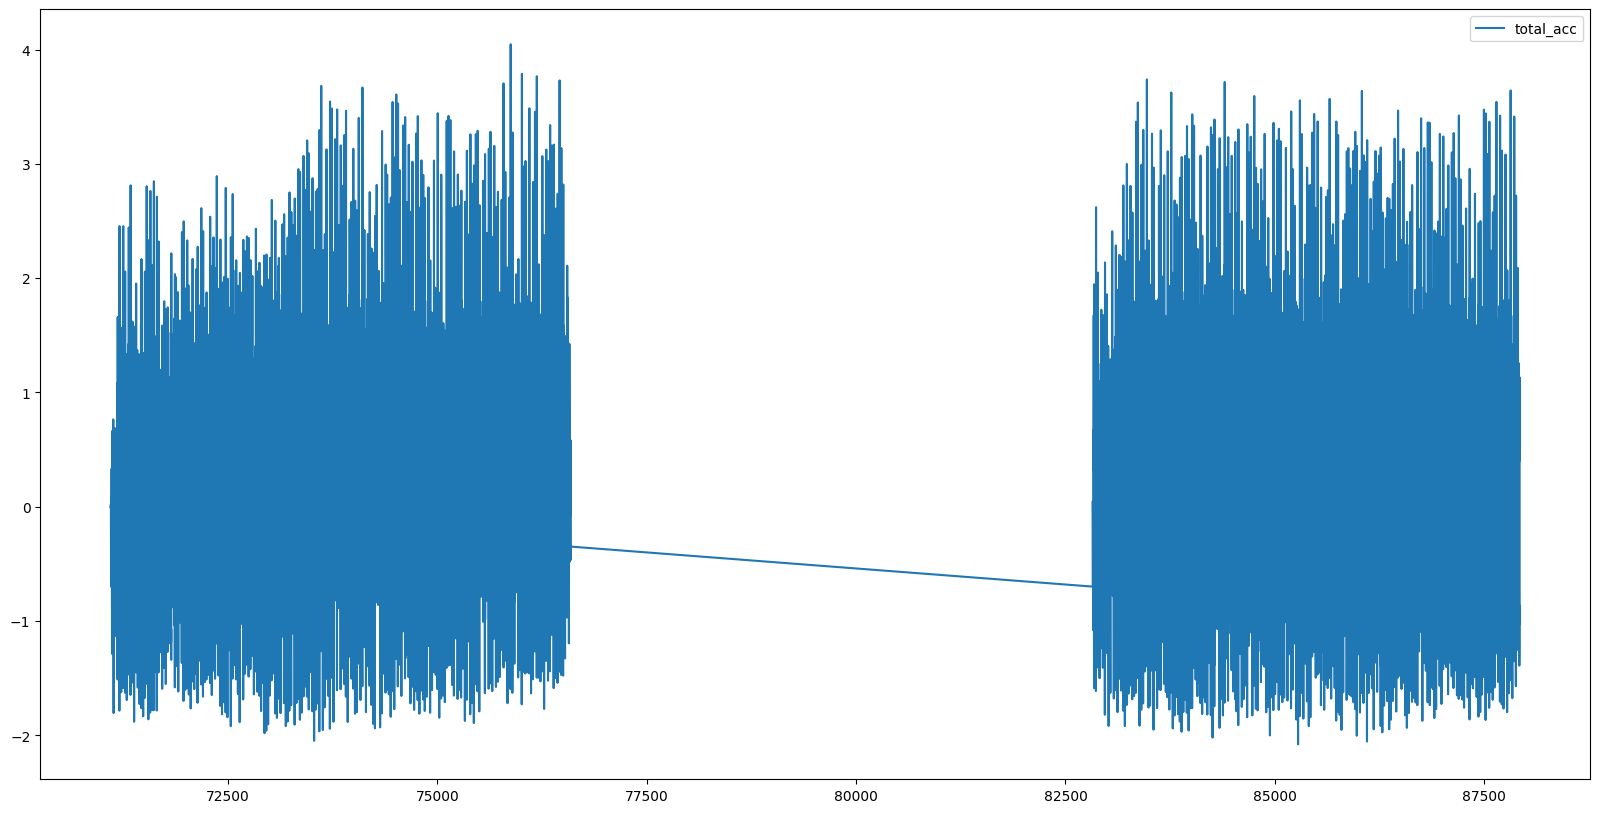

In [11]:
df_filtered[df_filtered['new_user_id'] == 6].plot(y=['total_acc'], figsize=(20, 10))


In [12]:
df_filtered.shape

(1255923, 7)

In [13]:
## Now, we group the data by new_user_id
df_grouped = df.groupby('new_user_id').agg(
    total_acc=('total_acc', list),
    x_acc=('x_acc', list),
    y_acc=('y_acc', list),
    z_acc=('z_acc', list),
    num_of_samples=('total_acc', 'count')
).reset_index()

# and add the signal length in seconds
df_grouped['signal_length_in_sec'] = df_grouped['num_of_samples'] * (1 / CONFIG.SAMPLING_RATE_HZ)

In [14]:
df_grouped.head(-1)

,new_user_id,total_acc,x_acc,y_acc,z_acc,num_of_samples,signal_length_in_sec
0,0,"[0.7362116837612153, 0.8161704566822283, 2.322...","[0.2941316, -0.49968776, -2.1783454, -2.797762...","[-0.6356053, -0.6044512, 0.7134906, 1.3548992,...","[-0.22693644, -0.22602014, 0.37201694, -0.2776...",999,49.95
1,1,"[9.886975653742438, 8.125557808895605, 9.72015...","[-2.3750482, 0.2681506, -1.0342951, -0.4596867...","[9.308656, 8.121132, 9.576807, 18.923769, 13.9...","[2.3367407, -0.0, 1.3024457, 1.4556746, 6.2823...",895,44.75
2,2,"[8.548147400078154, 16.371829569619063, 13.647...","[0.95, 4.21, 1.65, -2.34, -0.76, 5.63, 11.07, ...","[8.47, 15.79, 13.53, 13.48, 10.27, 17.77, 14.6...","[0.6537767, 0.9942854, -0.6946377, 1.4573772, ...",11598,579.90
3,3,"[7.28078292493328, 7.352883788011341, 8.934774...","[6.09, 6.36, 7.63, 7.63, 9.04, 9.7, 12.07, 11....","[3.99, 3.68, 4.63, 5.71, 6.47, 6.59, 7.12, 3.7...","[-0.04, -0.27, -0.42, -0.53, 0.08, 1.69, 4.9, ...",16532,826.60
4,4,"[8.569699812771304, 8.151999094615707, 8.86106...","[2.1650977, 3.3530273, 5.077441, 5.987549, 6.1...","[-7.980205, -7.4245605, -7.261699, -6.619834, ...","[2.2513185, 0.2969824, 0.07664063, 1.350791, 1...",1192,59.60
...,...,...,...,...,...,...,...
186,186,"[9.03762138481475, 9.666917078020536, 9.830306...","[0.9125633, 1.7978859, 2.5333846, 1.4982382, 0...","[3.336985, 4.7943625, 4.7943625, 3.759216, 2.6...","[8.349273, 8.19945, 8.19945, 9.00305, 10.50128...",12511,625.55
187,187,"[5.779359826139916, 5.019940238688107, 12.4594...","[-2.76, -0.93, 5.79, 7.4, 6.85, -0.27, -1.23, ...","[5.05, 4.9, 11.03, 11.26, 11.65, 9.7, 8.39, 9....","[-0.53, 0.57, 0.23, 0.69, 1.92, -1.38, -0.34, ...",24193,1209.65
188,188,"[19.128811721591596, 10.912638167579226, 7.689...","[-3.41, 1.27, -2.49, -1.65, 0.76, -5.18, -2.83...","[18.12, 10.8, 6.82, 8.31, 10.69, 9.23, 11.35, ...","[-5.09401, -0.9125633, -2.5333846, 1.2258313, ...",12201,610.05
189,189,"[9.118407293930515, 9.336124063844188, 9.49632...","[-1.0726024, -0.49799395, -1.340753, -2.413355...","[4.8267107, 4.7117887, 4.865018, 4.4436383, 3....","[7.661445, 8.0445175, 8.0445175, 9.423577, 9.6...",4372,218.60


In [79]:
# mean, median, std, max, min of signal length
df_grouped['signal_length_in_sec'].describe()

count     192.000000
mean      327.063281
std       293.957638
min         1.250000
25%       120.287500
50%       289.475000
75%       402.012500
max      2100.000000
Name: signal_length_in_sec, dtype: float64

<Axes: >

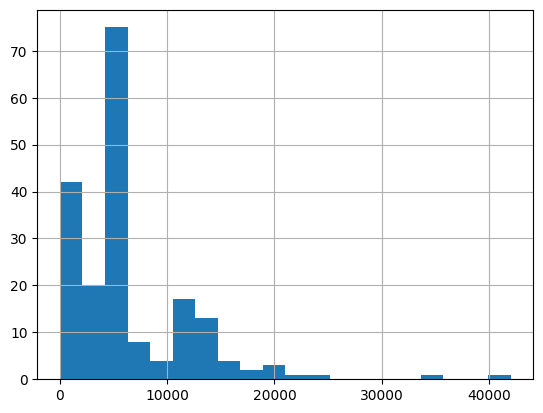

In [78]:
# plot a histogram of the number of samples per user
df_grouped['num_of_samples'].hist(bins=20)

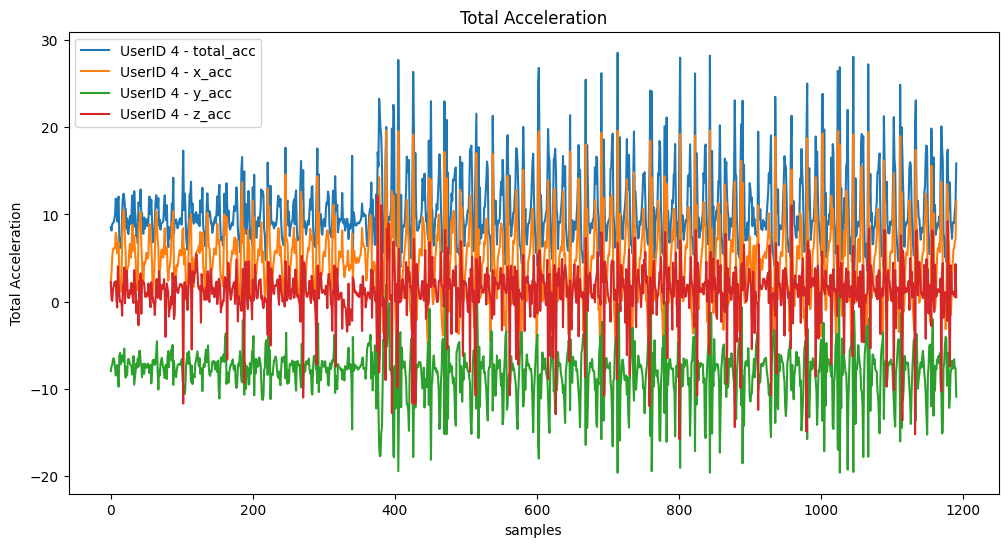

In [67]:
def plot_signal(df: pd.DataFrame, 
                columns: list[str], 
                title: str = None, 
                xlabel: str = None, 
                ylabel: str = None, 
                start: int = 0, 
                limit: int = 10, 
                unique_users: bool = False, 
                single_user: bool = False,
                exact_user_id: int = None
                ):
    plt.close()
    plt.figure(figsize=(12, 6))
    
    if exact_user_id:
        df = df[df['new_user_id'] == exact_user_id]

    else:
        if single_user:
            random_user = df['new_user_id'].sample(1).values[0]
            df = df[df['new_user_id'] == random_user]

        if unique_users:
            df = df.drop_duplicates(subset='new_user_id')
        
    if limit:
        if limit <= start:
            raise ValueError('Limit must be greater than start')
        df = df.iloc[start:limit]
        
    for _, row in df.iterrows():
        for col in columns:
            plt.plot(row[col], label=f'UserID {row["new_user_id"]} - {col}')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Assuming subsequences_df is the dataframe created previously
plot_signal(df_grouped, 
            columns=['total_acc', 'x_acc', 'y_acc', 'z_acc'], 
            title='Total Acceleration', 
            xlabel='samples', 
            ylabel='Total Acceleration', 
            unique_users=False, 
            start=0, 
            limit=5, 
            single_user=True, 
            exact_user_id=4)

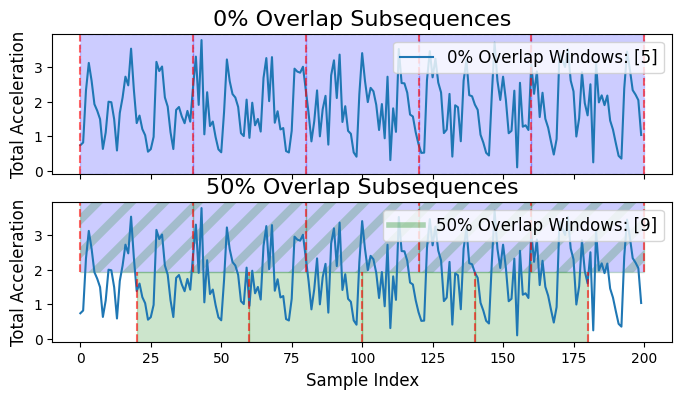

In [97]:
# Sample data
temp_data = df_grouped.iloc[0]['total_acc'][:200]

window_size = 40
overlap_50 = window_size // 2
overlap_0 = window_size

boundaries_50_overlap = [i for i in range(0, len(temp_data) - window_size + 1, overlap_50)]
boundaries_0_overlap = [i for i in range(0, len(temp_data) - window_size + 1, overlap_0)]


plt.rcParams['hatch.linewidth'] = 6
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4), sharex=True, sharey=True)

ax1.plot(temp_data, label='Total Acceleration')
ax2.plot(temp_data, label='Total Acceleration')

y_min, y_max = ax1.get_ylim()
y_mid = (y_max + y_min) / 2

for i in boundaries_0_overlap:
    ax1.axvspan(i, i + window_size, color='blue', linestyle='--', alpha=0.2)
    ax1.axvline(x=i, color='red', linestyle='--', alpha=0.6)
ax1.axvline(x=boundaries_0_overlap[-1] + window_size, color='red', linestyle='--', alpha=0.6)
ax1.set_title('0% Overlap Subsequences', fontsize=16)
ax1.legend([f'0% Overlap Windows: [{len(boundaries_0_overlap)}]'], fontsize=12, loc='upper right')

for idx, i in enumerate(boundaries_50_overlap):
    if idx % 2 == 0:
        ax2.axvspan(i, i + window_size, ymin=0.5, ymax=1, facecolor='blue', alpha=0.2, edgecolor='green', hatch='/')
        ax2.axvline(x=i, color='red', linestyle='--', alpha=0.6, ymin=0.5, ymax=1)
    else:
        ax2.axvspan(i, i + window_size, ymin=0, ymax=0.5, color='green', alpha=0.2)
        ax2.axvline(x=i, color='red', linestyle='--', alpha=0.6, ymin=0, ymax=0.5)
ax2.axvline(x=boundaries_50_overlap[-1] + window_size, color='red', linestyle='--', ymin=0.5, alpha=0.6)
ax2.axvline(x=boundaries_50_overlap[-2] + window_size, color='red', linestyle='--', ymin=0, ymax=0.5, alpha=0.6)


ax2.set_title('50% Overlap Subsequences', fontsize=16)
handles = [plt.Line2D([0], [0], color='green', lw=4, alpha=0.3)]
labels = [f'50% Overlap Windows: [{len(boundaries_50_overlap)}]']
ax2.legend(handles, labels, fontsize=12, loc='upper right')

# Set common labels
plt.xlabel('Sample Index', fontsize=12)
ax1.set_ylabel('Total Acceleration', fontsize=12)
ax2.set_ylabel('Total Acceleration', fontsize=12)


plt.savefig('plots/50_percent_overlap.png')
# Show the plot
plt.show()

In [24]:
# print how long the signal for user x is
df_grouped[df_grouped['new_user_id'] == 17]['signal_length_in_sec']

17    25.0
Name: signal_length_in_sec, dtype: float64

In [23]:
df_grouped[df_grouped['new_user_id'] == 99]['signal_length_in_sec']

99    922.6
Name: signal_length_in_sec, dtype: float64

In [22]:
df_grouped[df_grouped['new_user_id'] == 117]['signal_length_in_sec']

117    309.85
Name: signal_length_in_sec, dtype: float64

In [117]:
df_grouped.head()

,new_user_id,total_acc,x_acc,y_acc,z_acc,num_of_samples,signal_length_in_sec
0,0,"[0.7362116837612153, 0.8161704566822283, 2.322...","[0.2941316, -0.49968776, -2.1783454, -2.797762...","[-0.6356053, -0.6044512, 0.7134906, 1.3548992,...","[-0.22693644, -0.22602014, 0.37201694, -0.2776...",999,49.95
1,1,"[9.886975653742438, 8.125557808895605, 9.72015...","[-2.3750482, 0.2681506, -1.0342951, -0.4596867...","[9.308656, 8.121132, 9.576807, 18.923769, 13.9...","[2.3367407, -0.0, 1.3024457, 1.4556746, 6.2823...",895,44.75
2,2,"[8.548147400078154, 16.371829569619063, 13.647...","[0.95, 4.21, 1.65, -2.34, -0.76, 5.63, 11.07, ...","[8.47, 15.79, 13.53, 13.48, 10.27, 17.77, 14.6...","[0.6537767, 0.9942854, -0.6946377, 1.4573772, ...",11598,579.90
3,3,"[7.28078292493328, 7.352883788011341, 8.934774...","[6.09, 6.36, 7.63, 7.63, 9.04, 9.7, 12.07, 11....","[3.99, 3.68, 4.63, 5.71, 6.47, 6.59, 7.12, 3.7...","[-0.04, -0.27, -0.42, -0.53, 0.08, 1.69, 4.9, ...",16532,826.60
4,4,"[8.569699812771304, 8.151999094615707, 8.86106...","[2.1650977, 3.3530273, 5.077441, 5.987549, 6.1...","[-7.980205, -7.4245605, -7.261699, -6.619834, ...","[2.2513185, 0.2969824, 0.07664063, 1.350791, 1...",1192,59.60


In [118]:
# split each signal into 10 second windows
def split_sequences(row, sampling_frequency: int = 20, subsequence_duration: int = 10):
    samples_per_subsequence = sampling_frequency * subsequence_duration
    n_subsequences = int(row['signal_length_in_sec'] / subsequence_duration)
    subsequences = []
    for i in range(n_subsequences):
        start_idx = int(i * (samples_per_subsequence / 2))
        end_idx = start_idx + samples_per_subsequence

        # print(f"Start: {start_idx}, End: {end_idx}")

        if end_idx > row['num_of_samples']:
            break
        subsequences.append({
            'new_user_id': row['new_user_id'],
            'total_acc': row['total_acc'][start_idx:end_idx],
            'x_acc': row['x_acc'][start_idx:end_idx],
            'y_acc': row['y_acc'][start_idx:end_idx],
            'z_acc': row['z_acc'][start_idx:end_idx],
            'num_of_samples': samples_per_subsequence,
            'signal_length_in_sec': subsequence_duration
        })
    return subsequences

all_subsequences = []

# subsequences_df = grouped_df.apply(lambda row: split_sequences(row, CONFIG.SAMPLING_RATE_HZ, 10), axis=1)

for index, row in df_grouped.iterrows():
    all_subsequences.extend(split_sequences(row, CONFIG.SAMPLING_RATE_HZ, 2))

df_subsequences = pd.DataFrame(all_subsequences)

In [119]:
df_subsequences.head()

,new_user_id,total_acc,x_acc,y_acc,z_acc,num_of_samples,signal_length_in_sec
0,0,"[0.7362116837612153, 0.8161704566822283, 2.322...","[0.2941316, -0.49968776, -2.1783454, -2.797762...","[-0.6356053, -0.6044512, 0.7134906, 1.3548992,...","[-0.22693644, -0.22602014, 0.37201694, -0.2776...",40,2
1,0,"[1.3777305229373487, 1.5960753374387007, 1.203...","[1.1114693, 1.215011, 0.9126327, 0.21197024, 0...","[-0.6337727, -0.82894415, -0.40378192, -0.9318...","[-0.5109888, -0.6197228, -0.67347896, -0.37812...",40,2
2,0,"[2.425892007118064, 3.302566174850101, 1.90556...","[1.4813483, 2.0045543, 1.8689423, 1.7660115, 0...","[-1.9147571, -2.6212227, -0.3643811, -3.342960...","[-0.15577064, -0.1337795, -0.07391469, -0.0665...",40,2
3,0,"[0.9513855617281761, 1.9683277319562844, 1.314...","[0.66767573, -1.0225884, 0.19639318, -0.015882...","[-0.6423248, 1.6542231, 1.2999213, -1.4358387,...","[0.21624629, -0.3036, 0.019242255, -0.42760566...",40,2
4,0,"[2.329359891123871, 1.6620954042937637, 0.8495...","[-1.8026633, -0.8240572, 0.4560109, 1.2605205,...","[1.3573426, 1.325883, 0.46822822, -0.1301143, ...","[0.57787853, 0.5705481, 0.54275376, 0.66553766...",40,2


#### Breakpoint 1
Here we could save the dataset to be used in a classical LSTM approach, as we still have the time series information.

In [104]:
df_grouped[df_grouped['new_user_id'] == 2]['signal_length_in_sec']

2    579.9
Name: signal_length_in_sec, dtype: float64

In [120]:
# split off one user for testing
test_user_id = 186
df_subsequences_test = df_subsequences[df_subsequences['new_user_id'] == test_user_id]
df_subsequences = df_subsequences[df_subsequences['new_user_id'] != test_user_id]

# save the data
df_subsequences_test.to_csv('subsequences_test_raw.csv', index=False)
df_subsequences.to_csv('subsequences_raw.csv', index=False)

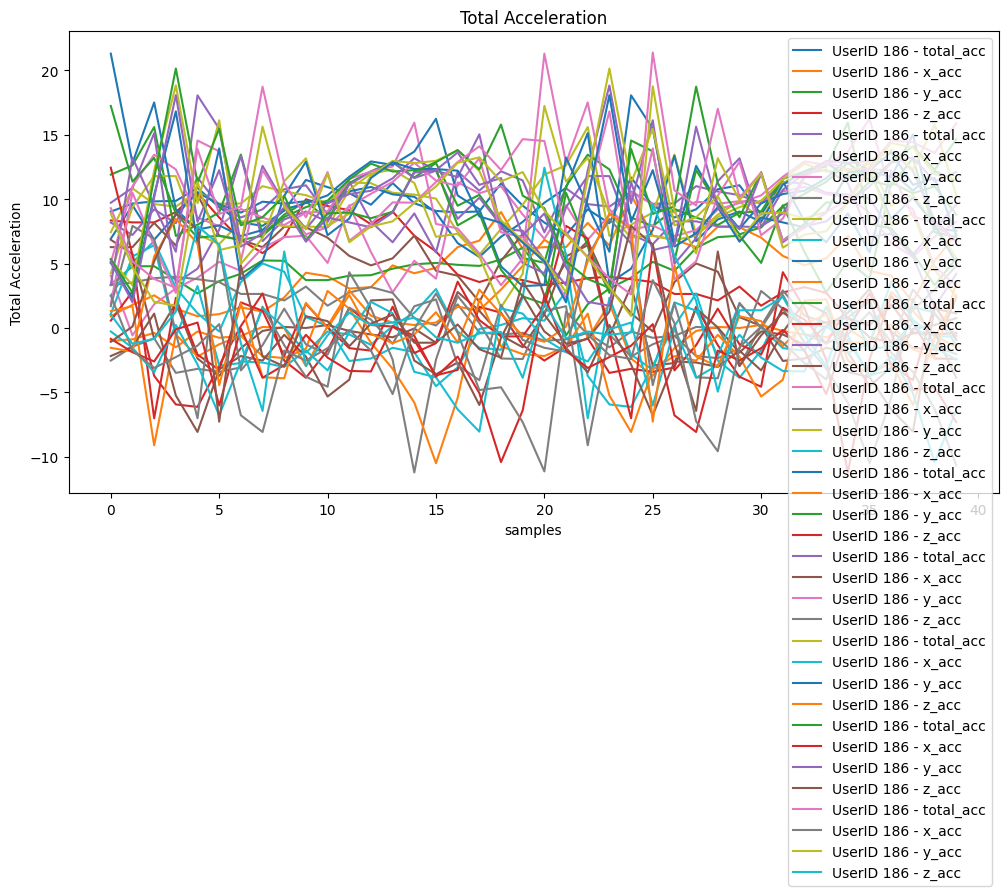

In [121]:
plot_signal(df_subsequences_test, 
            columns=['total_acc', 'x_acc', 'y_acc', 'z_acc'], 
            title='Total Acceleration', 
            xlabel='samples', 
            ylabel='Total Acceleration',
            )

For the CNN approach, we will use these identified subsequences and analyze them with aggregate metrics. <br>
<b>Erratum:</b> We did not pursue this approach in the end.

In [77]:
# now we do some feature engineering 
## FFT: dominant frequency, power in each frequency band; Mean, Median, Variance, Skewness, Kurtosis;
# Function to compute FFT dominant frequency
def dominant_frequency(sequence, sampling_rate):
    n = len(sequence)
    freqs = np.fft.fftfreq(n, d=1/sampling_rate)
    fft_values = np.abs(fft(sequence))
    peak_freq = freqs[np.argmax(fft_values)]
    return peak_freq

# Function to extract features from a sequence
def extract_features(sequence, sampling_rate):
    mean_val = np.mean(sequence)
    median_val = np.median(sequence)
    variance_val = np.var(sequence)
    skewness_val = skew(sequence)
    kurtosis_val = kurtosis(sequence)
    dominant_freq = dominant_frequency(sequence, sampling_rate)
    
    return mean_val, median_val, variance_val, skewness_val, kurtosis_val, dominant_freq



features = ['mean', 'median', 'variance', 'skewness', 'kurtosis', 'dominant_freq']
columns = ['total_acc', 'x_acc', 'y_acc', 'z_acc']


feature_data = []

for index, row in df_subsequences.iterrows():
    feature_row = [row['new_user_id']]
    for col in columns:
        mean_val, median_val, variance_val, skewness_val, kurtosis_val, dominant_freq = extract_features(row[col], CONFIG.SAMPLING_RATE_HZ)
        feature_row.extend([mean_val, median_val, variance_val, skewness_val, kurtosis_val, dominant_freq])
    feature_data.append(feature_row)

# Create a DataFrame for the extracted features
feature_columns = ['new_user_id']
for col in columns:
    for feature in features:
        feature_columns.append(f'{col}_{feature}')

df_features = pd.DataFrame(feature_data, columns=feature_columns)

C:\Users\Lks\AppData\Local\Temp\ipykernel_10284\123249361.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness_val = skew(sequence)
C:\Users\Lks\AppData\Local\Temp\ipykernel_10284\123249361.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis_val = kurtosis(sequence)


In [81]:
print(df_features.shape)
df_features.head()

(6177, 25)


,new_user_id,total_acc_mean,total_acc_median,total_acc_variance,total_acc_skewness,total_acc_kurtosis,total_acc_dominant_freq,x_acc_mean,x_acc_median,x_acc_variance,...,y_acc_variance,y_acc_skewness,y_acc_kurtosis,y_acc_dominant_freq,z_acc_mean,z_acc_median,z_acc_variance,z_acc_skewness,z_acc_kurtosis,z_acc_dominant_freq
0,0,1.840200,1.861919,0.760927,0.145365,-0.858203,0.0,-0.030551,0.209069,2.270853,...,1.605154,0.075085,-0.769831,0.8,0.031020,-0.068570,0.203014,0.179779,-0.970232,0.8
1,0,1.870561,1.767568,0.801052,0.440720,-0.374840,0.0,0.083718,0.246026,2.281194,...,1.652524,-0.085960,-0.302853,0.0,0.011289,-0.104763,0.200682,0.390091,-0.764662,0.9
2,0,1.878479,1.697852,0.899815,0.495426,-0.455187,0.0,-0.009328,0.171042,2.332620,...,1.742240,-0.223810,-0.270002,0.9,0.020635,-0.099571,0.230706,0.237466,-0.878185,0.9
3,0,1.881086,1.794751,0.889815,0.484908,-0.344437,0.0,0.081784,0.289245,2.292704,...,1.753193,-0.262767,-0.385034,0.0,-0.008213,-0.055894,0.198269,0.234628,-0.716947,0.8
4,1,9.807108,9.326571,11.765461,0.370347,-0.517919,0.0,4.715620,4.769250,7.977552,...,12.639106,0.692446,-0.154662,0.0,1.475211,1.455675,5.036002,0.024733,0.499413,0.0


In [82]:
df_features.to_csv('subsequences_features.csv', index=False)